# Bead Size

This module will demonstrate how to find the size of the beads in the cluster images. The pipeline will be:

- Load cluster images
- Scale up image
- Find all connected pixels in foreground using flood-fill (this step erodes the image)
- Get boundary
- Use area of boundary to approximate a circle
- Dilate circle to compensate for erosion in flood-fill
- Find area of dilated circle
- Approximate new circle based on area
- Convert diameter of circle from pixels to nanometers
- Plot the diameters of all beads in a histogram

In [1]:
import modules.oiplib as oiplib

from skimage import morphology
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
clusters = oiplib.loadImages("../images/clusters")

We load all the images and find the approximate diameters of each bead as described in the beginning

In [3]:
sizes = []

for cluster in clusters:
    # Find beads
    
    labelImg = oiplib.labelRegionWatershed(cluster)
    beads, areas = np.unique(labelImg, return_counts=True)
    
    # Approximate the diameter of each bead
    
    diameters = []
    
    for area in areas[1:]: # We skip the first element as it is the background
        diameters.append(oiplib.areaToDiameter(area))
        
    # Find the area of each bead, compensating for erosion
    
    compAreas = []
    
    for diameter in diameters: 
        compAreas.append(oiplib.dilateBead(diameter, labelImg.shape))
        
    # We approximate the diameters using the compensated areas
    
    diameters = []
    
    for area in compAreas:
        diameters.append(oiplib.areaToDiameter(area)/10) # We divide by 10, as we scaled the image up 10
        
    # Write the diameters to the global array
    
    for diameter in diameters:
        sizes.append(oiplib.pixelDiameterToSizenm(diameter))


We floor the sizes so that they arranged in bins of 1 nanometer

In [4]:
flooredSizes = np.floor(sizes).astype(np.uint8)
flooredSizes = np.unique(flooredSizes, return_counts=True)

Collect the data in a dictionary for easy processing

In [5]:
sizesDict = dict()

for i in range(np.max(flooredSizes[1])):
    sizesDict[i] = 0
    

for i, size in enumerate(flooredSizes[0]):
    sizesDict[size] = flooredSizes[1][i]


Plot the histogram

Text(0, 0.5, 'Number of beads')

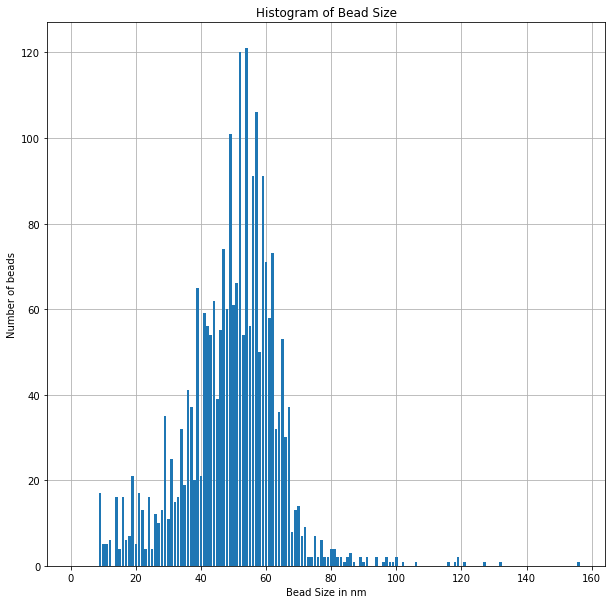

In [6]:
# General histogram variables.
maxBeadSize = max(sizesDict.keys())
maxCount = max(sizesDict.values())
xAxis = np.arange(1, maxBeadSize + 1)
yHist = np.zeros(maxBeadSize)

# Create histogram.
for key, value in sizesDict.items():
    yHist[key - 1] = value
    
fig, ax = plt.subplots(figsize=(10, 10))
plot = ax.bar(xAxis, yHist)
ax.grid()
ax.set_axisbelow(True)
ax.set_title("Histogram of Bead Size")
ax.set_xlabel("Bead Size in nm")
ax.set_ylabel("Number of beads")